In [2]:
import numpy as np
import pandas as pd
import glob
import string

from sklearn.model_selection import train_test_split,cross_val_score
from nltk.tag import pos_tag

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Importing Dataset

We import the CSV files

In [3]:
all_data = pd.DataFrame()
for f in glob.glob("./data/*.csv"):
    df = pd.read_csv(f)
    all_data = all_data.append(df,ignore_index=True)

In [4]:
all_data.info()
all_data = all_data.sample(frac=1).reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2414 entries, 0 to 2413
Data columns (total 20 columns):
id                       2414 non-null float64
id_str                   2414 non-null float64
screen_name              2414 non-null object
location                 1273 non-null object
description              1945 non-null object
url                      1257 non-null object
followers_count          2414 non-null int64
friends_count            2414 non-null int64
listedcount              2414 non-null int64
created_at               2414 non-null object
favourites_count         2414 non-null int64
verified                 2414 non-null bool
statuses_count           2414 non-null int64
lang                     2414 non-null object
status                   2343 non-null object
default_profile          2414 non-null bool
default_profile_image    2414 non-null bool
has_extended_profile     2414 non-null bool
name                     2414 non-null object
bot                      2414 

In [5]:
all_data.shape

(2414, 20)

In [6]:
train, test = train_test_split(all_data, test_size = 0.2)

In [7]:
train.shape , test.shape

((1931, 20), (483, 20))

# Visualizing Data

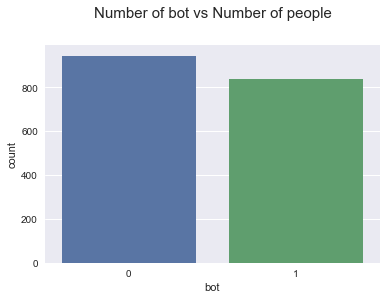

In [7]:
plt.title('Number of bot vs Number of people', y=1.1, size=15)
sns.countplot('bot', data=train)

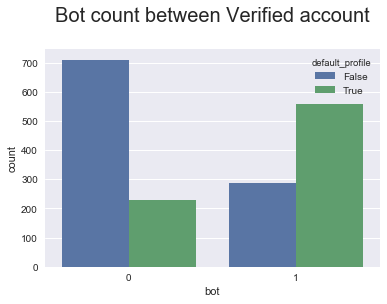

In [8]:
plt.title('Bot count between Verified account', size=20, y=1.1)
sns.countplot(x = 'bot', hue='default_profile', data=train)

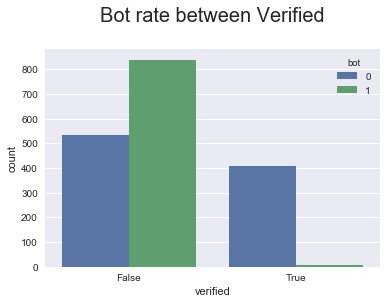

In [10]:
plt.title('Bot rate between Verified', size=20, y=1.1)
sns.countplot(x='verified', hue='bot', data=train)

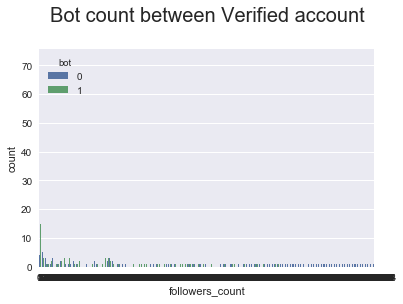

In [11]:
plt.title('Bot count between Verified account', size=20, y=1.1)
sns.countplot(x = 'followers_count', hue='bot', data=train)

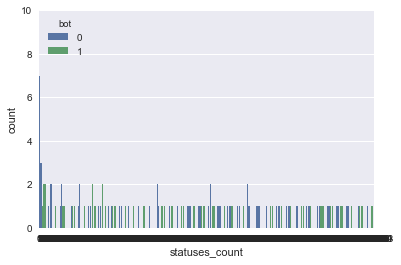

In [38]:
plt.xlim(0, 10)
plt.ylim(0, 10)
sns.countplot(x = 'statuses_count', hue='bot', data=train)

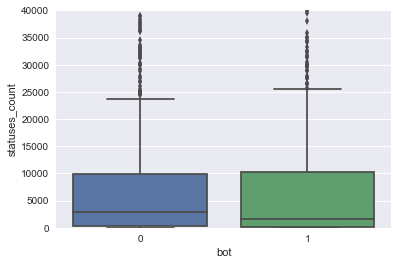

In [32]:
plt.ylim(0, 40000)
sns.boxplot(x='bot', y='statuses_count', data=train)

count    1.785000e+03
mean     9.689370e+05
std      5.355878e+06
min      0.000000e+00
25%      4.500000e+01
50%      3.430000e+02
75%      1.307100e+04
max      9.632156e+07
Name: followers_count, dtype: float64

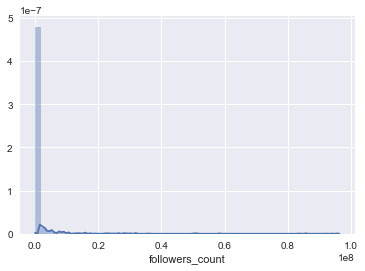

In [11]:
sns.distplot(train['followers_count'])
train['followers_count'].describe()

In [65]:
def lexical_diversity(text):
  if len(text) == 0:
    diversity = 0
  else: 
    diversity = float(len(set(text))) / len(text)
  return diversity

def screenname_format(text):
  if text[-2:].isdigit():
    return True
  else: 
    return False

def screenname_length(text):
    return len(text)

In [67]:
train.loc[:,'last_numeric'] = train.screen_name.apply(screenname_format)
train.loc[:,'sn_length'] = train.screen_name.apply(screenname_length)

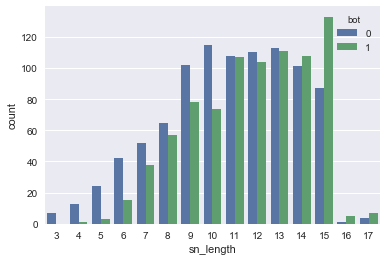

In [69]:
sns.countplot(x ='sn_length', hue='bot' ,data=train)

In [13]:
grouped = train['screen_name']
train['diversity'] = grouped.apply(lexical_diversity)
df1 = train[['diversity','bot']]
bot_diversity  = df1.ix[(df1['bot']==1)]
Nonbot_diversity = df1.ix[(df1['bot']==0)]
bot_diversity.shape, Nonbot_diversity.shape

/Users/Vignesh/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


((845, 2), (940, 2))

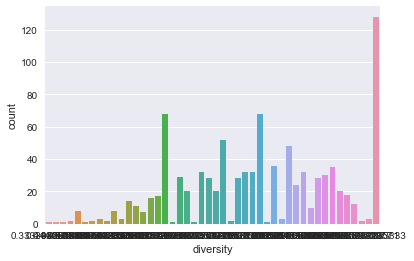

In [14]:
sns.countplot(x = Nonbot_diversity['diversity'], data=Nonbot_diversity)

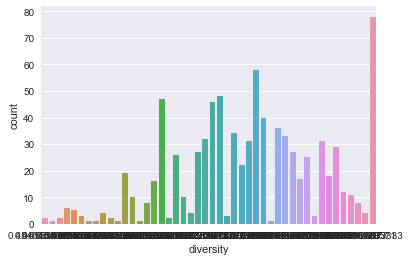

In [15]:
sns.countplot(x = bot_diversity['diversity'], data=bot_diversity)

# Transforming Features

Since we must deal with numerical feature, we should convert all the following in a binary vector 0/1.
1. verified 
2. default_profile 
3. default_profile_image 
4. has_extended_profile 

In [8]:
train['followers_count'].describe()

count    1.931000e+03
mean     8.724249e+05
std      4.696562e+06
min      0.000000e+00
25%      5.300000e+01
50%      3.250000e+02
75%      7.046500e+03
max      9.689749e+07
Name: followers_count, dtype: float64

In [23]:
def returnDates(x):
    formated_date = ''
    months = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}
    if x.startswith('"') and x.endswith('"'): x = x[1:-1]
    if x.startswith("'") and x.endswith("'"): x = x[1:-1]
    if x.startswith("'"): x = x[1:]
    date_split = x.split(' ')
    if len(date_split) == 1:
        _date = date_split[0].split('/')
        _date[2] = '20'+_date[2]
        formated_date = '/'.join(map(str,_date))
        #print formated_date , date_split, pd.to_datetime(formated_date, format='%m%d%Y', errors='coerce')
    elif len(date_split) == 2:
        _date = date_split[0].split('/')
        formated_date = '/'.join(map(str,[_date[0],_date[1],_date[2]]))
        #print formated_date , date_split, pd.to_datetime(formated_date, format='%m%d%Y', errors='coerce')
    elif len(date_split) == 6:
        m = months[date_split[1]]
        formated_date = '/'.join(map(str,[m,date_split[2],date_split[5]]))
        if formated_date[-1] == '"': formated_date = formated_date[:-1]
        #print formated_date, date_split, pd.to_datetime(formated_date, format='%m%d%Y', errors='coerce')
    
    return pd.to_datetime(formated_date, format='%m/%d/%Y', errors='coerce')

In [24]:
import sys
from datetime import date
import datetime as dt
import json
train, test = train_test_split(all_data, test_size = 0.2)
def ff_ratio(df):
    df.followers_count = df.followers_count.apply(lambda x: int(x)+1)
    df.friends_count = df.friends_count.apply(lambda x: int(x)+1)
    df.loc[:,'ff_ratio'] = (df.followers_count/df.friends_count)
    return df
    
def simplfy_followerscount(df):
    bins = (0, 46,358,14917,96321560,sys.maxint)
    group_names = ['1_quartile', '2_quartile', '3_quartile', '4_quartile', '5_quartile']
    categories = pd.cut(df.followers_count, bins, labels=group_names)
    df.followers_count = categories
    return df  

def simplfy_friendscount(df):
    bins = (0, 10,197,671,978964,sys.maxint)
    group_names = ['1_quartile', '2_quartile', '3_quartile', '4_quartile', '5_quartile']
    categories = pd.cut(df['friends_count'], bins, labels=group_names)
    df.friends_count = categories
    return df    

def simplfy_listedcount(df):
    df.loc[:,'listedcount']= df.listedcount.apply(lambda x: int(x)+1)
    bins = (0, 2,18,360,222411,sys.maxint)
    group_names = ['1_quartile', '2_quartile', '3_quartile', '4_quartile', '5_quartile']
    categories = pd.cut(df['listedcount'], bins, labels=group_names)
    df.loc[:,'listedcount'] = categories
    return df    

def simplfy_favouritescount(df):
    df.loc[:,'favourites_count']= df.favourites_count.apply(lambda x: int(x)+1)
    bins = (0,2,25,484,714021,sys.maxint)
    group_names = ['1_quartile', '2_quartile', '3_quartile', '4_quartile', '5_quartile']
    categories = pd.cut(df.favourites_count, bins, labels=group_names)
    df.loc[:,'favourites_count']= categories
    return df  

def simplfy_statusescount(df):
    df.loc[:,'statuses_count']= df.statuses_count.apply(lambda x: int(x)+1)
    df.loc[:,'tweets_per_day'] = df.statuses_count/df.acc_age
    bins = (0,178,2290,10025,6863363,sys.maxint)
    group_names = ['1_quartile', '2_quartile', '3_quartile', '4_quartile', '5_quartile']
    categories = pd.cut(df.statuses_count, bins, labels=group_names)
    df.loc[:,'statuses_count']= categories
    return df 

def drop_features(df):
    return df.drop(['id', 'id_str', 'location','lang','status','description','name','screen_name','url','created_at'], axis=1)

def replace_None(df):
    df.loc[:,'has_extended_profile'] = df['has_extended_profile'].fillna(df.has_extended_profile.median())
    return df

def format_date(df):
    df.loc[:,'modified_date'] = df.created_at.apply(returnDates)
    return df;

def datetime_created(x):
    date_split = x.strip().split(',')
    formated_date = '/'.join(map(str,[date_split[1].strip(),date_split[2].strip(),date_split[0].strip()]))
    return pd.to_datetime(formated_date, format='%m/%d/%Y', errors='coerce')    
    
def created_date_status(x):
    y = x
    if isinstance(x, str) and x.find("created_at") != -1:
        index = x.find("created_at") + 13
        x = x[index:(index+32)]
        if bool(x.strip()) and x.find("datetime") == -1:
            x = returnDates(x)
        else:
            index = y.find("created_at") + 28
            y = y[index:]
            x = y[y.find("(")+1:y.find(")")]
            x = datetime_created(x)
    else:
        x = pd.to_datetime('03/13/2017', format='%m/%d/%Y', errors='coerce')
    return x

def account_age(df):
    df['status_created_at'] = df.status.apply(created_date_status)
    df['acc_age'] = (df['status_created_at'] - df['modified_date'])
    df['acc_age'] = df.acc_age.apply(lambda  x:int(x.days))
    for index,row in df.iterrows():
        if row['acc_age'] < 0:
            value = abs(int((pd.to_datetime('03/13/2017', format='%m/%d/%Y', errors='coerce') - pd.to_datetime(row['modified_date'])).days))
            df.set_value(index,'acc_age',value)
    df['acc_age'] += 1
    return df;



def transform_features(df):
    df = ff_ratio(df)
    df = simplfy_followerscount(df)
    df = simplfy_friendscount(df)
    df = simplfy_listedcount(df)
    df = simplfy_favouritescount(df)
    df = format_date(df)
    df = account_age(df)
    df = simplfy_statusescount(df)   
    df = replace_None(df)  
    df = drop_features(df)
    return df

train = transform_features(train)
test = transform_features(test)
train.head(5)

C:\Users\hp\Anaconda2\lib\site-packages\ipykernel\__main__.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\hp\Anaconda2\lib\site-packages\ipykernel\__main__.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\hp\Anaconda2\lib\site-packages\ipykernel\__main__.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

,followers_count,friends_count,listedcount,favourites_count,verified,statuses_count,default_profile,default_profile_image,has_extended_profile,bot,ff_ratio,modified_date,status_created_at,acc_age,tweets_per_day
2396,1_quartile,2_quartile,1_quartile,2_quartile,False,1_quartile,True,False,False,0,0.400000,2017-02-17,2017-02-17,1,14.000000
767,2_quartile,2_quartile,1_quartile,3_quartile,False,3_quartile,False,False,False,0,1.444444,2009-08-22,2014-08-23,1828,2.981947
771,1_quartile,3_quartile,1_quartile,1_quartile,False,1_quartile,True,False,False,1,0.046154,2017-02-20,2016-08-31,22,0.090909
2061,4_quartile,3_quartile,4_quartile,4_quartile,True,4_quartile,False,False,False,0,192.865546,2009-02-28,2017-04-08,2962,15.952397
2156,2_quartile,3_quartile,1_quartile,1_quartile,False,1_quartile,True,False,True,1,0.188153,2014-11-03,2017-03-28,877,0.014823


In [25]:
x = train[(train['bot'] == 0)]
xm = np.mean(x['acc_age'])

In [26]:
print xm

2058.15690169


In [27]:
x.describe()

,bot,ff_ratio,acc_age,tweets_per_day
count,1007.0,1.007000e+03,1007.000000,1007.000000
mean,0.0,4.500381e+04,2058.156902,7.487342
std,0.0,5.677285e+05,1059.963859,41.531158
min,0.0,5.555556e-03,1.000000,0.000413
25%,0.0,5.504114e-01,1133.000000,0.347667
50%,0.0,4.960912e+00,2453.000000,1.619892
75%,0.0,5.079910e+02,2911.000000,4.468577
max,0.0,1.142873e+07,3900.000000,861.123941


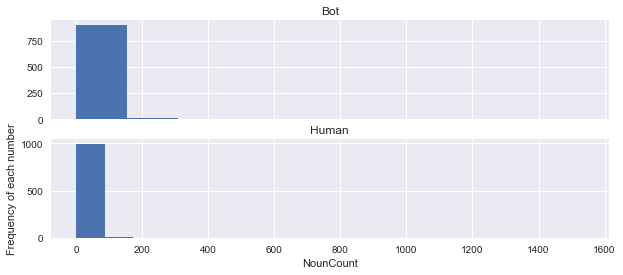

In [28]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,4))


ax1.hist(train.tweets_per_day[train.bot == 1])
ax1.set_title('Bot')

ax2.hist(train.tweets_per_day[train.bot == 0])
ax2.set_title('Human')

plt.xlabel('NounCount')
plt.ylabel('Frequency of each number')
plt.show()

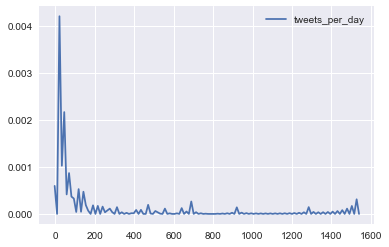

In [29]:
df1 = train[['tweets_per_day','bot']]
bot_len  = df1.ix[(df1['bot']==1)]
sns.kdeplot(bot_len['tweets_per_day'])

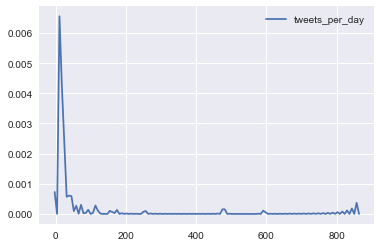

In [30]:
df1 = train[['tweets_per_day','bot']]
bot_len  = df1.ix[(df1['bot']==0)]
sns.kdeplot(bot_len['tweets_per_day'])

In [31]:
train.loc[train['acc_age'] < 0 ,"acc_age"]

Series([], Name: acc_age, dtype: int64)

In [32]:
returnDates('1/27/17')

Timestamp('2017-01-27 00:00:00')

In [33]:
train['acc_age']

2396       1
767     1828
771       22
2061    2962
2156     877
538        1
2140    3189
2022    1707
2266     595
159     2799
2107    2901
808     3026
1560     174
486      431
2356    2960
2064    2904
1317     224
2090    1533
46       783
1489     355
1917     703
1330     878
413      580
1248     641
1582    2554
1622     431
1568     580
1736    1171
1737    1959
1189    2951
        ... 
1771    2743
1532    2317
2379    2385
1601     996
815      705
1273     877
445      580
1865    2784
2269    1648
77       877
1109     432
172     2883
1329       1
476     2749
1670    2950
1662    2995
390     3167
2364     100
2341    2593
799      182
382        1
1439      92
461      877
2283     877
1376    3276
792     2970
400        1
893     2916
593     1396
1783    2685
Name: acc_age, dtype: int64

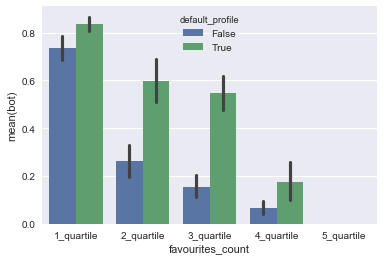

In [34]:
sns.barplot(x="favourites_count", y="bot", hue="default_profile", data=train);

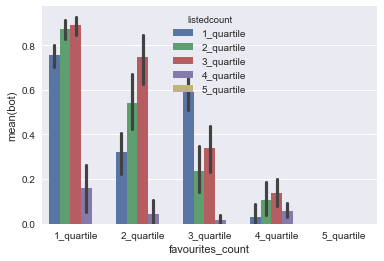

In [35]:
sns.barplot(x="favourites_count", y="bot", hue="listedcount", data=train);

# Final Encoding

The LabelEncoder in Scikit-learn will convert each unique string value into a number, making out data more flexible for various algorithms.

In [36]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['followers_count','friends_count','listedcount','favourites_count','verified','statuses_count', \
                'default_profile','default_profile_image','has_extended_profile','ff_ratio','acc_age','tweets_per_day']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train.loc[:,feature] = le.transform(df_train[feature])
        df_test.loc[:,feature] = le.transform(df_test[feature])
    return df_train, df_test
    
train, test = encode_features(train, test)
train.head()

,followers_count,friends_count,listedcount,favourites_count,verified,statuses_count,default_profile,default_profile_image,has_extended_profile,bot,ff_ratio,modified_date,status_created_at,acc_age,tweets_per_day
2396,0,1,0,1,0,0,1,0,0,0,412,2017-02-17,2017-02-17,0,1573
767,1,1,0,2,0,2,0,0,0,0,716,2009-08-22,2014-08-23,704,1058
771,0,2,0,0,0,0,1,0,0,1,113,2017-02-20,2016-08-31,16,195
2061,3,2,3,3,1,3,0,0,0,0,1268,2009-02-28,2017-04-08,1148,1593
2156,1,2,0,0,0,0,1,0,1,1,266,2014-11-03,2017-03-28,428,84


In [37]:
train_output = pd.DataFrame(data=train, columns =list(train))
test_output = pd.DataFrame(data=test, columns =list(test))

# Use pandas to write the comma-separated output file
train_output.to_csv("./cleanedData/Bot_Training.csv", index=False)
test_output.to_csv("./cleanedData/Bot_Testing.csv", index=False)

# Splitting up the Training Data


First, separate the features(X) from the labels(y).
* X_all: All features minus the value we want to predict (Bot).
* y_all: Only the value we want to predict.

Second, use Scikit-learn to randomly shuffle this data into four variables. In this case, Training 80% of the data, then testing against the other 20%.

Later, this data will be reorganized into a KFold pattern to validate the effectiveness of a trained algorithm

In [38]:
from sklearn.model_selection import train_test_split

X_all = train.drop(['bot','modified_date'], axis=1)
y_all = train['bot']

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=23)

In [39]:
X_train.shape, y_train.shape

((1544, 13), (1544L,))

In [40]:
X_test.shape, y_test.shape

((387, 13), (387L,))

In [41]:
list(X_train)

['followers_count',
 'friends_count',
 'listedcount',
 'favourites_count',
 'verified',
 'statuses_count',
 'default_profile',
 'default_profile_image',
 'has_extended_profile',
 'ff_ratio',
 'status_created_at',
 'acc_age',
 'tweets_per_day']

# Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV


clf = RandomForestClassifier()

parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

acc_scorer = make_scorer(accuracy_score)

#grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

clf.fit(X_train, y_train)

TypeError: float() argument must be a string or a number

In [43]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

NotFittedError: Estimator not fitted, call `fit` before exploiting the model.

In [44]:
from sklearn.cross_validation import KFold

def run_kfold(clf):
    kf = KFold(891, n_folds=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf:
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(clf)

C:\Users\hp\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


TypeError: float() argument must be a string or a number

In [45]:
clf.feature_importances_

array([ 0.1240734 ,  0.18518641,  0.03280783,  0.21354566,  0.16214292,
        0.01942156,  0.03081   ,  0.00121361,  0.00461966,  0.22617895])

In [46]:
list(X_train)

['followers_count',
 'friends_count',
 'listedcount',
 'favourites_count',
 'verified',
 'statuses_count',
 'default_profile',
 'default_profile_image',
 'has_extended_profile',
 'ff_ratio']

In [35]:
from sklearn.tree import export_graphviz
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

visualize_tree(clf,list(X_train))

AttributeError: 'RandomForestClassifier' object has no attribute 'tree_'

In [67]:
def get_Noun(x):
    word = x.strip()
    count = 0
    tagged_sent = pos_tag(word.split())
    for w in tagged_sent:
        if w[1] == 'NNP':
            count+=1
        if w[1] == 'VBZ':
            count-=1
    return count

In [68]:
df['name'] = df['name'].fillna("")
train['NounCount'] = df['name'].apply(get_Noun)

In [69]:
train['NounCount'].describe()

count    939.000000
mean       1.436635
std        0.932120
min        0.000000
25%        0.000000
50%        2.000000
75%        2.000000
max        3.000000
Name: NounCount, dtype: float64

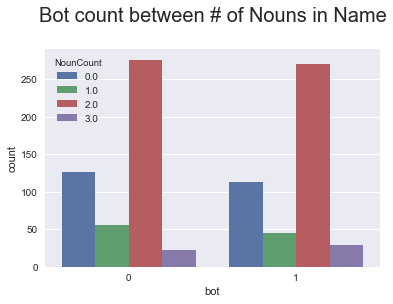

In [70]:
plt.title('Bot count between # of Nouns in Name', size=20, y=1.1)
sns.countplot(x = 'bot', hue='NounCount', data=train)

In [71]:
train['created_at'][0]

Timestamp('2010-07-13 00:00:00')

In [21]:
from datetime import date
import calendar
print type(train['created_at'])
train['days'] = train['created_at'].apply(lambda x: calendar.day_name[x.weekday()])

KeyError: 'created_at'

In [74]:
train['days'].describe()

count         1785
unique           7
top       Thursday
freq           291
Name: days, dtype: object

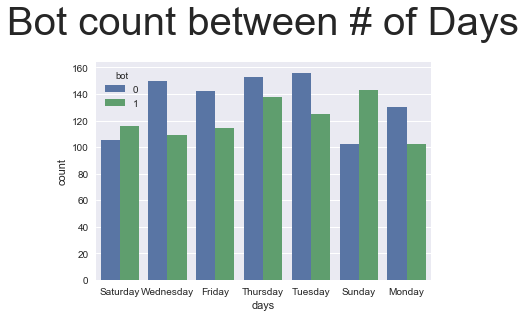

In [77]:
plt.title('Bot count between # of Days', size=40, y=1.1)
sns.countplot(x = 'days', hue='bot', data=train)

,id,id_str,screen_name,location,description,url,followers_count,friends_count,listedcount,created_at,favourites_count,verified,statuses_count,lang,status,default_profile,default_profile_image,has_extended_profile,name,bot
2084,5.817313e+07,58173133,Maheshbhupathi,"��T: 19.057273,72.825963","An Outlier,Twice over!",https://t.co/hOkJ2t0a4I,947045,271,2618,7/19/09,88,True,4905,en,"Status(contributors=None, truncated=False, tex...",False,False,False,Mahesh Bhupathi,0
1798,1.453254e+07,14532539,tonyromo,"Dallas, TX",Official twitter account of Dallas Cowboys QB ...,NaN,351335,19,1221,4/25/08,395,True,25,en,"Status(contributors=None, truncated=False, tex...",False,False,False,Tony Romo,0
354,2.205977e+09,2205976656,magicpixx,NaN,Follow me for algorithmically-curated pictures...,NaN,10250,10378,194,Thu Nov 21 01:14:23 +0000 2013,211,False,262067,en,"{u'contributors': None, u'truncated': False, u...",True,False,False,Magic Pics,1


(1785, 20)
(1785, 9)
(1785,)


/Users/Vignesh/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/Vignesh/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,followers_count,friends_count,listedcount,favourites_count,verified,statuses_count,default_profile,default_profile_image,has_extended_profile
57,1047,299,28,958,False,3098,False,False,False
1361,35,134,7,17,False,989,False,False,False
1141,4,28,0,0,False,2,True,False,True


In [20]:
cross_val_score(clf, train, bot, cv=2)

ValueError: could not convert string to float: False

In [28]:
from sklearn.datasets import load_iris
from sklearn import tree
clf = tree.DecisionTreeClassifier()
iris = load_iris()
clf = clf.fit(iris.data, iris.target)
tree.export_graphviz(clf,out_file='tree.dot') 